## Bic Vu's Capstone Project
#### ML Guild - Apprentice Cohort 11
#### Notebook 1
2023-04-13

In [37]:
import pandas as pd
import pandas_profiling as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 12) # Expand number char shown to 12 instead of scientific notation

from datetime import date
today = date.today()

In [56]:
# Create calculate_feature_statistics for quick feature overview
from pandas.api.types import is_numeric_dtype

def calculate_feature_statistics(data_frame):
    results = pd.DataFrame()
    for column in data_frame.columns:
        column_data = data_frame[column]
        if not is_numeric_dtype(column_data): continue
        num_zeros = (column_data == 0).sum()
        prop_zeros = num_zeros / len(column_data)
        num_positives = (column_data > 0).sum()
        prop_positives = num_positives / len(column_data)
        num_negatives = (column_data < 0).sum()
        prop_negatives = num_negatives / len(column_data)
        num_missing = column_data.isnull().sum()
        prop_missing = num_missing / len(column_data)
        #most_frequent_value = column_data.mode()[0]
        nunique_value = column_data.nunique()
        prop_nunique = nunique_value / len(column_data)
        min_value = column_data.min()
        max_value = column_data.max()
        median_value = column_data.median()
        feature_stats = pd.Series([num_zeros, prop_zeros, num_positives, prop_positives,
                                   num_negatives, prop_negatives, num_missing, prop_missing,
                                   #most_frequent_value, 
                                   nunique_value, prop_nunique, min_value, max_value, median_value],
                                  index=['num_zeros', 'prop_zeros', 'num_positives', 'prop_positives',
                                         'num_negatives', 'prop_negatives', 'num_missing', 'prop_missing',
                                         #'most_frequent_value', 
                                         'nunique_value', 'prop_nunique', 'min_value', 'max_value', 'median_value'])
        results[column] = feature_stats
    return results.T

In [3]:
# Create shortcut functions to display max rows and columns
def maxcol():
    pd.set_option('display.max_columns', None)
    return

def maxcol_reset():
    pd.reset_option('display.max_columns', None)
    return

def maxrow():
    pd.set_option('display.max_rows', None)
    return

def maxrow_reset():
    pd.reset_option('display.max_rows', None)
    return

### Opt 1: Import raw data

In [ ]:
# Get column names
filepath = "data/2021_lar.txt"
samp = pd.read_csv(filepath, sep="|", nrows=100)
print(samp.columns)

In [ ]:
#### Read in selected columns of data
filepath = "data/2021_lar.txt"
cols = ['census_tract', 'derived_race', 'action_taken', 'loan_amount', 'property_value', 'income', 'debt_to_income_ratio', 'tract_minority_population_percent', 'tract_to_msa_income_percentage']

hmda = pd.read_csv(filepath, sep="|", usecols=cols)

In [ ]:
print(hmda.shape)
hmda.head()

In [ ]:
hmda.dtypes

In [ ]:
# Export to save file
from datetime import date
today = date.today()

# Parquet can't convert multiple format columns?
# hmda.to_parquet("data/output/hmda_2021_sel_"+str(today), index=None)

hmda.to_csv("data/output/hmda_2021_sel_"+str(today)+".csv", index=None)

#### Filter out unused data

In [ ]:
# Check for unsual properties in object columns. This has already been done on previous runs.

# maxrow()
# hmda.action_taken.value_counts()
# hmda.census_tract.value_counts()
# hmda.property_value.value_counts()
# hmda.derived_race.value_counts()

In [ ]:
# Filter for action_taken
## 1 - Loan originated -- "Approved" KEEP
# 2 - Application approved but not accepted
## 3 - Application denied -- "Denied" KEEP
# 4 - Application withdrawn by applicant
# 5 - File closed for incompleteness
# 6 - Purchased loan
# 7 - Preapproval request denied
# 8 - Preapproval request approved but not accepted
# Select application action

hmda = hmda.loc[(hmda["action_taken"]==1) | (hmda["action_taken"]==3)]
hmda.shape

In [ ]:
# Convert action_taken code
# Keep 1 as 1 for accepted values
# Convert 3 to 0 for rejected values

print(hmda["action_taken"].value_counts())
hmda["action_taken"] = hmda["action_taken"].apply(lambda x: x % 3)
hmda["action_taken"].value_counts()

In [ ]:
# Drop values not used on race
print(hmda.shape)
hmda = hmda.loc[~((hmda["derived_race"]=="Race Not Available") | (hmda["derived_race"]=="Free Form Text Only"))]
# df = df.loc[~((df['team'] == 'A') | (df['assists'] > 6))]
print(hmda.shape)

In [ ]:
# Drop property_value that are "Exempt", leaving only numberic value
print(len(hmda))
hmda = hmda[hmda.property_value != "Exempt"]
print(len(hmda))

In [ ]:
hmda = hmda.dropna(how="any").reset_index(drop=True)

In [ ]:
# Export to save file

# Parquet can't convert multiple format columns?
# hmda.to_parquet("data/output/hmda_2021_sel_"+str(today), index=None)

hmda.to_csv("data/output/hmda_2021_sel_"+str(today)+".csv", index=None)

### Opt 2: Import saved sample data

In [4]:
# Skip Opt 1 and import selected data rows
hmda = pd.read_csv("data/output/hmda_2021_sel_2023-04-14.csv")
print(hmda.shape)
hmda.head()

/var/folders/2x/fv33h81566l4630885xd8kn40000gp/T/ipykernel_14419/564161503.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hmda = pd.read_csv("data/output/hmda_2021_sel_2023-04-14.csv")


(14512260, 9)


,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage
0,8059012022.0,White,1,335000,545000.0,15.0,NaN,11.78,140.0
1,51640070101.0,White,1,115000,185000.0,36.0,NaN,24.07,66.0
2,16027021001.0,White,1,115000,215000.0,21.0,NaN,39.60,79.0
3,6073008348.0,White,1,455000,715000.0,20.0,NaN,71.40,130.0
4,6013317000.0,White,1,325000,565000.0,36.0,NaN,29.35,71.0


#### Converting data types and formating geographic ids

In [5]:
hmda.dtypes

census_tract                          object
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                       float64
income                               float64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [6]:
hmda["property_value"] = pd.to_numeric(hmda["property_value"])
hmda.dtypes

census_tract                          object
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                       float64
income                               float64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [7]:
# Check how many census tracts are null. Will be using geography to combine with social capital data
nan = len(hmda[hmda["census_tract"]=="nA"])
nan

1

In [8]:
# Some census tract values have decimals
hmda = hmda[hmda["census_tract"] != "nA"]
hmda["census_tract"] = pd.to_numeric(hmda["census_tract"])

In [9]:
# Check if any floats contains decimal before converting to ints
print((hmda["census_tract"] % 1  != 0).sum())
print((hmda["property_value"] % 1  != 0).sum())
print((hmda["income"] % 1  != 0).sum())

83312
614758
882087


In [21]:
# Convert floats to ints
# May need to dropnas first
hmda = hmda.dropna(how="any").reset_index(drop=True)

# convert_dict = {"census_tract": "int",
#                 "property_value": "int",
#                 "income": "int"
#                 }
 
# hmda = hmda.astype(convert_dict, errors='ignore')

# hmda[["census_tract", "property_value", "income"]] = hmda[["census_tract", "property_value", "income"]].round(0).astype(int)

hmda = hmda.astype({
    "census_tract": "int",
    "property_value": "int",
    "income": "int"
})

hmda.dtypes

census_tract                           int64
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                         int64
income                                 int64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [22]:
# If census tract is a float, convert to an int then a string
hmda["census_tract"] = hmda["census_tract"].astype(str)
hmda.dtypes

census_tract                          object
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                         int64
income                                 int64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [23]:
# Create a column to count the length of census tract strings
hmda["ct_count"] = hmda["census_tract"].str.len()
hmda.tail()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,ct_count
13051998,12099003509,White,1,755000,1005000,5801,<20%,4.74,215.0,11
13051999,42091205200,White,1,995000,2255000,6361,<20%,10.47,178.0,11
13052000,4013216816,White,1,905000,1575000,6711,<20%,14.79,179.0,10
13052001,6037274202,White,1,2325000,2905000,9154,<20%,15.56,273.0,10
13052002,6017031700,Asian,1,595000,1085000,240,30%-<36%,23.70,236.0,10


In [24]:
# check how many tracts have 11 char or other lengths
hmda.ct_count.value_counts()

11    10253939
10     2798064
Name: ct_count, dtype: int64

In [25]:
# Fill census_tract with leading 0 if less than 11 characters

hmda['census_tract'] = hmda['census_tract'].apply(lambda x: x.zfill(11))
hmda.tail()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,ct_count
13051998,12099003509,White,1,755000,1005000,5801,<20%,4.74,215.0,11
13051999,42091205200,White,1,995000,2255000,6361,<20%,10.47,178.0,11
13052000,04013216816,White,1,905000,1575000,6711,<20%,14.79,179.0,10
13052001,06037274202,White,1,2325000,2905000,9154,<20%,15.56,273.0,10
13052002,06017031700,Asian,1,595000,1085000,240,30%-<36%,23.70,236.0,10


In [26]:
# Drop ct_count column used for data validation
hmda = hmda.drop(["ct_count"], axis=1)

#### Convert tract_to_msa_income_percentage to categorical data

In [27]:
# How the data source org CFPB uses tract to msa income to determine income level for lending
# https://www.consumerfinance.gov/data-research/consumer-credit-trends/mortgages/lending-neighborhood-income-level/

bins = [0,50, 80, 120, max(hmda["tract_to_msa_income_percentage"])]
bin_labels = ["low", "moderate", "middle", "upper"]

In [28]:
hmda["income_level"] = pd.cut(hmda["tract_to_msa_income_percentage"], bins, labels=bin_labels)
hmda["income_level"] = hmda["income_level"].astype(str)
hmda.head()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,income_level
0,06075030900,Joint,1,975000,1675000,123,20%-<30%,54.88,146.0,upper
1,06059052422,White,1,1125000,1925000,179,50%-60%,40.81,159.0,upper
2,06111005600,White,1,675000,1055000,114,45,46.59,110.0,middle
3,06061023800,White,1,335000,495000,68,38,9.39,101.0,middle
4,06085503330,Asian,1,1285000,2175000,115,50%-60%,89.83,174.0,upper


<function matplotlib.pyplot.show(close=None, block=None)>

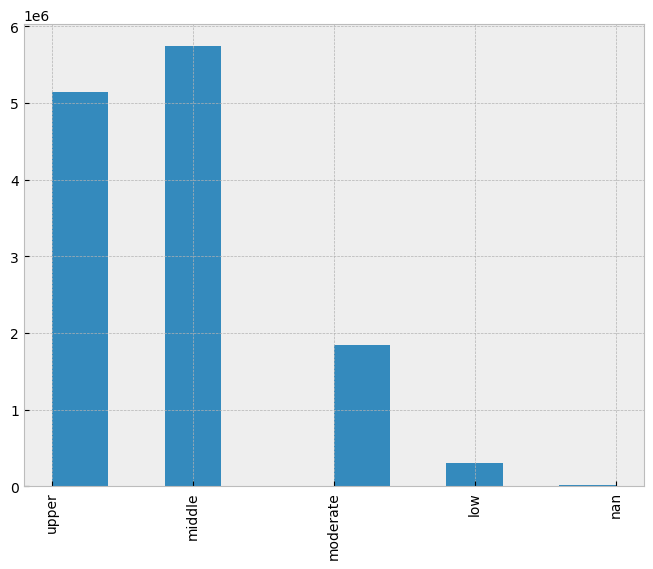

In [29]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=[8, 6])
plt.xticks(rotation='vertical')

plt.hist(hmda["income_level"])

plt.show

### ETL Debt to Income Ratio
The DTI metric has a lot of categories with few values
<p><a href = https://www.chase.com/personal/credit-cards/education/basics/what-is-debt-to-income-ratio-and-why-it-is-important#:~:text=Debt%2Dto%2Dincome%20ratio%20of,loan%20or%20line%20of%20credit.>Debt to Income categories</a>

In [30]:
hmda["debt_to_income_ratio"].value_counts()

20%-<30%    2841057
30%-<36%    2282709
<20%        1248579
50%-60%      659430
44           480573
42           474383
>60%         462503
41           447894
40           441553
39           439254
43           437250
38           425028
37           417229
36           408893
49           355946
45           339497
46           299544
48           297116
47           292857
Exempt          706
47.0              1
41.0              1
Name: debt_to_income_ratio, dtype: int64

In [31]:
# Map new categories
mapping ={
    "<20%": "<20%",
    "20%-<30%": "20%-<30%",
    "30%-<36%": "30%-<36%",
    "36": "36%-<42%",
    "37": "36%-<42%",
    "38": "36%-<42%",
    "39": "36%-<42%",
    "40": "36%-<42%",
    "41": "36%-<42%",
    "42": "42%-<50%",
    "43": "42%-<50%",
    "44": "42%-<50%",
    "45": "42%-<50%",
    "46": "42%-<50%",
    "47": "42%-<50%",
    "48": "42%-<50%",
    "49": "42%-<50%",
    "50%-60%": "50%-60%",
    ">60%": ">60%"}

hmda["dti_level"] = hmda["debt_to_income_ratio"].map(mapping)
hmda["dti_level"] = hmda["dti_level"].astype(str)
hmda["dti_level"].value_counts()

42%-<50%    2977166
20%-<30%    2841057
36%-<42%    2579851
30%-<36%    2282709
<20%        1248579
50%-60%      659430
>60%         462503
nan             708
Name: dti_level, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

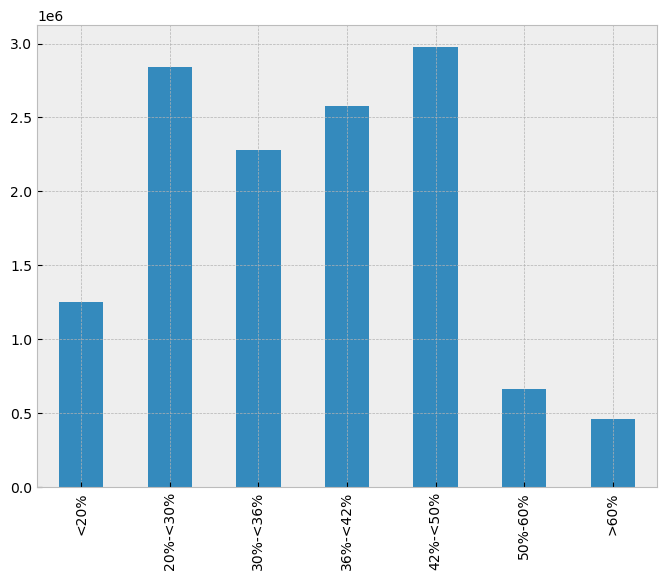

In [32]:
plt.figure(figsize=[8, 6])
plt.xticks(rotation='vertical')

# plt.hist(hmda["dti_level"]).loc(sort)

sort = ["<20%", "20%-<30%", "30%-<36%", "36%-<42%", "42%-<50%", "50%-60%", ">60%"]
hmda["dti_level"].value_counts().loc[sort].plot(kind='bar', legend=None)

plt.show

In [33]:
print(hmda.shape)
hmda.tail(60)

(13052003, 11)


,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,income_level,dti_level
13051943,06073003204,Joint,1,1035000,1305000,1575,<20%,70.36,131.0,upper,<20%
13051944,06037408705,Asian,1,685000,865000,1587,<20%,89.29,91.0,middle,<20%
13051945,06073005100,Asian,1,235000,315000,1595,30%-<36%,56.04,38.0,low,30%-<36%
13051946,06073005600,Asian,1,215000,285000,1597,20%-<30%,30.34,162.0,upper,20%-<30%
13051947,06037534405,White,1,285000,505000,1736,<20%,98.78,53.0,moderate,<20%
13051948,06037534405,White,1,565000,755000,1739,<20%,98.78,53.0,moderate,<20%
13051949,06083000502,Joint,0,1785000,3085000,1786,<20%,15.45,158.0,upper,<20%
13051950,06037534405,White,1,285000,505000,1736,<20%,98.78,53.0,moderate,<20%
13051951,06037700802,White,1,1855000,2715000,1769,20%-<30%,22.85,184.0,upper,20%-<30%
13051952,06059032058,White,1,2225000,2965000,1795,<20%,38.34,186.0,upper,<20%


In [34]:
# drop original columns used to generate categorical data
hmda = hmda.drop(["debt_to_income_ratio", "tract_to_msa_income_percentage"], axis=1)

In [35]:
print(hmda.shape)
hmda.dropna(how="any").reset_index(drop=True)
print(hmda.shape)

(13052003, 9)
(13052003, 9)


In [57]:
calculate_feature_statistics(hmda)

,num_zeros,prop_zeros,num_positives,prop_positives,num_negatives,prop_negatives,num_missing,prop_missing,nunique_value,prop_nunique,min_value,max_value,median_value
action_taken,1874123.0,0.143588918881,11177880.0,0.856411081119,0.0,0.000000000000,0.0,0.0,2.0,0.000000153233,0.0,1.0,1.00
loan_amount,0.0,0.000000000000,13052003.0,1.000000000000,0.0,0.000000000000,0.0,0.0,981.0,0.000075160878,5000.0,1409715000.0,235000.00
property_value,0.0,0.000000000000,13052003.0,1.000000000000,0.0,0.000000000000,0.0,0.0,1440.0,0.000110327894,5000.0,1410005000.0,355000.00
income,54912.0,0.004207170348,12987832.0,0.995083436619,9259.0,0.000709393033,0.0,0.0,7476.0,0.000572785648,-126000.0,381000000.0,94.00
tract_minority_population_percent,5281.0,0.000404612227,13046722.0,0.999595387773,0.0,0.000000000000,0.0,0.0,10591.0,0.000811446335,0.0,100.0,22.51


#### Export data

In [38]:
hmda.to_csv("data/output/hmda_2021_CLEAN_"+str(today)+".csv", index=False, header=True)

In [39]:
hmda.to_parquet("data/output/hmda_2021_CLEAN_"+str(today), index=False)

### Opt A: Group data by census tract ignore race

In [ ]:
# hmda= pd.read_parquet("data/output/hmda_2021_CLEAN_2023-04-14", index=False)

In [40]:
hmda.columns

Index(['census_tract', 'derived_race', 'action_taken', 'loan_amount',
       'property_value', 'income', 'tract_minority_population_percent',
       'income_level', 'dti_level'],
      dtype='object')

In [41]:
hmda.dtypes

census_tract                          object
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                         int64
income                                 int64
tract_minority_population_percent    float64
income_level                          object
dti_level                             object
dtype: object

In [42]:
# need to convert these categories to strings to get mode
hmda[["census_tract", "derived_race","income_level","dti_level"]] = hmda[["census_tract", "derived_race","income_level","dti_level"]].astype(str)

In [44]:
# Group by census tract
# Keep first value if multiple modes
mode = lambda x: pd.Series.mode(x)[0]

ct_group = hmda.groupby('census_tract', as_index=False).agg({
    'derived_race': mode,
    'action_taken': pd.Series.mean,
    "loan_amount": pd.Series.mean,
    "property_value": pd.Series.mean,
    "income": pd.Series.mean,
    'tract_minority_population_percent': pd.Series.mean,
    'income_level': mode,
    'dti_level': mode
})
print(ct_group.shape)
ct_group.tail()

(72684, 9)


,census_tract,derived_race,action_taken,loan_amount,property_value,income,tract_minority_population_percent,income_level,dti_level
72679,78010971300,Black or African American,1.0,165000.0,225000.0,62.0,0.0,middle,30%-<36%
72680,78010971500,Black or African American,1.0,175000.0,215000.0,123.0,0.0,middle,20%-<30%
72681,78020950200,White,0.0,1655000.0,2505000.0,1425.0,0.0,middle,<20%
72682,78030960100,White,1.0,175000.0,215000.0,173.0,0.0,middle,20%-<30%
72683,78030960400,Black or African American,0.5,365000.0,745000.0,94.5,0.0,upper,30%-<36%


In [45]:
ct_group = ct_group.rename(columns={'action_taken':'approval'})

#### Export

In [46]:
ct_group[["census_tract", "derived_race", "income_level", "dti_level"]]= ct_group[["census_tract", "derived_race", "income_level", "dti_level"]].astype(str)

In [47]:
ct_group.to_csv("data/output/hmda_2021_ct_group_"+str(today)+".csv", index=False, header=True)
ct_group.to_parquet("data/output/hmda_2021_ct_group_"+str(today), index=False)

### Opt B: Group by race

In [48]:
hmda["derived_race"].value_counts()

White                                        10515189
Asian                                         1074853
Black or African American                     1000392
Joint                                          322215
American Indian or Alaska Native                77992
Native Hawaiian or Other Pacific Islander       34169
2 or more minority races                        27193
Name: derived_race, dtype: int64

In [49]:
# Select race category and group by average action (percent of approval)

mode = lambda x: pd.Series.mode(x)[0]

black_group = hmda[hmda["derived_race"]=="Black or African American"].groupby('census_tract', as_index=False).agg({
    'action_taken': pd.Series.mean,
    "loan_amount": pd.Series.mean,
    "property_value": pd.Series.mean,
    "income": pd.Series.mean,
    'tract_minority_population_percent': pd.Series.mean,
    'income_level': mode,
    'dti_level': mode
})
print(black_group.shape)
black_group.tail(60)

(58363, 8)


,census_tract,action_taken,loan_amount,property_value,income,tract_minority_population_percent,income_level,dti_level
58263,72127009400,0.333333333333,85000.0,91666.666666666672,29.666666666667,99.43,middle,>60%
58264,72127009601,1.000000000000,75000.0,95000.000000000000,21.000000000000,98.46,upper,42%-<50%
58265,72127009602,1.000000000000,85000.0,95000.000000000000,52.000000000000,100.00,upper,20%-<30%
58266,72127009603,0.000000000000,105000.0,135000.000000000000,80.000000000000,99.12,upper,>60%
58267,72127009614,1.000000000000,115000.0,125000.000000000000,65.000000000000,98.35,upper,42%-<50%
...,...,...,...,...,...,...,...,...
58358,78010970900,1.000000000000,155000.0,155000.000000000000,102.000000000000,0.00,low,20%-<30%
58359,78010971200,1.000000000000,185000.0,245000.000000000000,146.000000000000,0.00,middle,<20%
58360,78010971300,1.000000000000,165000.0,225000.000000000000,62.000000000000,0.00,middle,30%-<36%
58361,78010971500,1.000000000000,175000.0,215000.000000000000,123.000000000000,0.00,middle,20%-<30%


In [50]:
black_group = black_group.rename(columns={'action_taken':'approval_black'})

#### Export

In [51]:
black_group[["census_tract", "income_level", "dti_level"]]= black_group[["census_tract", "income_level", "dti_level"]].astype(str)

In [52]:
black_group.to_csv("data/output/hmda_2021_black_group"+str(today)+".csv", index=False, header=True)
black_group.to_parquet("data/output/hmda_2021_black_group"+str(today), index=False)

#### Next step: Run the Capstone_BV_ETL_SC_20230413